# <u>LightGBM (LGBM) + Random Forest</u>
-Ademas hacemos optmizacion de hiperparametros -> Optuna o GridSearch mas extenso

-Tambien aplicamos Feature Engineering avanzado -> Crear nuevas caracteristicas a partir de las ya existentes.

Recordar que los features (caracteristicas) son las variables de entrada que el modelo usa para hacer predicciones. 

In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Primero se cargan los conjuntos de datos.

In [4]:
# Conjunto de datos de prueba
df_test = pd.read_csv('/home/carolina/Escritorio/Astrometria/practicos/Astrometria-2025/practico5_astrometria/galaxy_forming_burst_test.csv')
df_test.head()

ID          ra        dec         u         g         r  \
0  1237656906355048679  359.882500  -1.011695  19.34624  18.21367  17.75281   
1  1237648721225711796  168.508873  -0.007002  20.08095  18.58526  17.82388   
2  1237655473438851815  260.209844  26.321156  22.92703  20.01030  18.46797   
3  1237651274034184295  125.648654  52.388509  19.28477  17.77666  16.92267   
4  1237661125612142849  125.846050  25.560856  18.64250  17.84922  17.69156   

          i         z  modelFlux_u  modelFlux_g  ...  psfMag_g  psfMag_i  \
0  17.43699  17.23576    18.259090    51.824020  ...  20.46436  19.85486   
1  17.35917  17.01471     9.279436    36.803690  ...  19.69541  18.53301   
2  17.73924  17.28094     0.645773     9.904737  ...  22.06661  19.84510   
3  16.47363  16.18417    19.322850    77.505940  ...  19.22704  17.94705   
4  17.56612  17.48753    34.913430    72.495770  ...  18.96511  18.79242   

   psfMag_z   expAB_u   expAB_g   expAB_r   expAB_i   expAB_z  redshift  \
0  19.57471  0.349946  0.336899  0.342106  0.336519  0.316463  0.076849   
1  18.33405  0.300323  0.292062  0.304036  0.311175  0.337448  0.072482   
2  19.27482  0.137121  0.679532  0.661082  0.665039  0.767354  0.323387   
3  17.69468  0.597250  0.874807  0.918937  0.889690  0.838195  0.091731   
4  18.83481  0.421484  0.418764  0.461124  0.467602  0.421164  0.027804   

   redshift_err  
0      0.000012  
1      0.000009  
2      0.000057  
3      0.000010  
4      0.000006  

[5 rows x 40 columns]

In [5]:
# Conjunto de datos de entrenamiento
df_train = pd.read_csv('/home/carolina/Escritorio/Astrometria/practicos/Astrometria-2025/practico5_astrometria/galaxy_forming_burst_train.csv')
df_train.head()


ID          ra        dec         u         g         r  \
0  1237663542066479839  316.862138  -0.895678  19.01775  17.64755  17.06249   
1  1237655124482064438  206.623360   3.878296  17.04417  15.99764  15.55414   
2  1237655501889667673  258.396808  29.744604  19.07817  17.60122  16.84234   
3  1237648722837700815  171.667200   1.135270  18.92527  17.69376  16.97346   
4  1237655469672890715  229.001991   2.406898  18.13839  16.88722  16.26597   

          i         z  modelFlux_u  modelFlux_g  ...  psfMag_i  psfMag_z  \
0  16.70350  16.49018     24.71067     87.29298  ...  19.10930  18.70515   
1  15.37217  15.18734    152.17130    398.97420  ...  18.04992  17.76888   
2  16.36071  16.06588     23.37314     91.09844  ...  18.18285  17.70473   
3  16.52742  16.25693     26.90786     83.65588  ...  17.73501  17.39894   
4  15.89510  15.62886     55.54449    175.83760  ...  18.22657  17.90952   

    expAB_u   expAB_g   expAB_r   expAB_i   expAB_z  redshift  redshift_err  \
0  0.671345  0.651463  0.666413  0.690870  0.621546  0.096112      0.000009   
1  0.367797  0.279793  0.260749  0.232302  0.240708  0.017826      0.000006   
2  0.292335  0.307789  0.323592  0.328726  0.323058  0.080695      0.000008   
3  0.648844  0.734394  0.779769  0.773851  0.777902  0.137939      0.000008   
4  0.443804  0.372774  0.364403  0.368019  0.372280  0.038428      0.000008   

   target  
0       1  
1       0  
2       1  
3       0  
4       1  

[5 rows x 41 columns]

## `Graficos con analisis exploratorio de Datos`

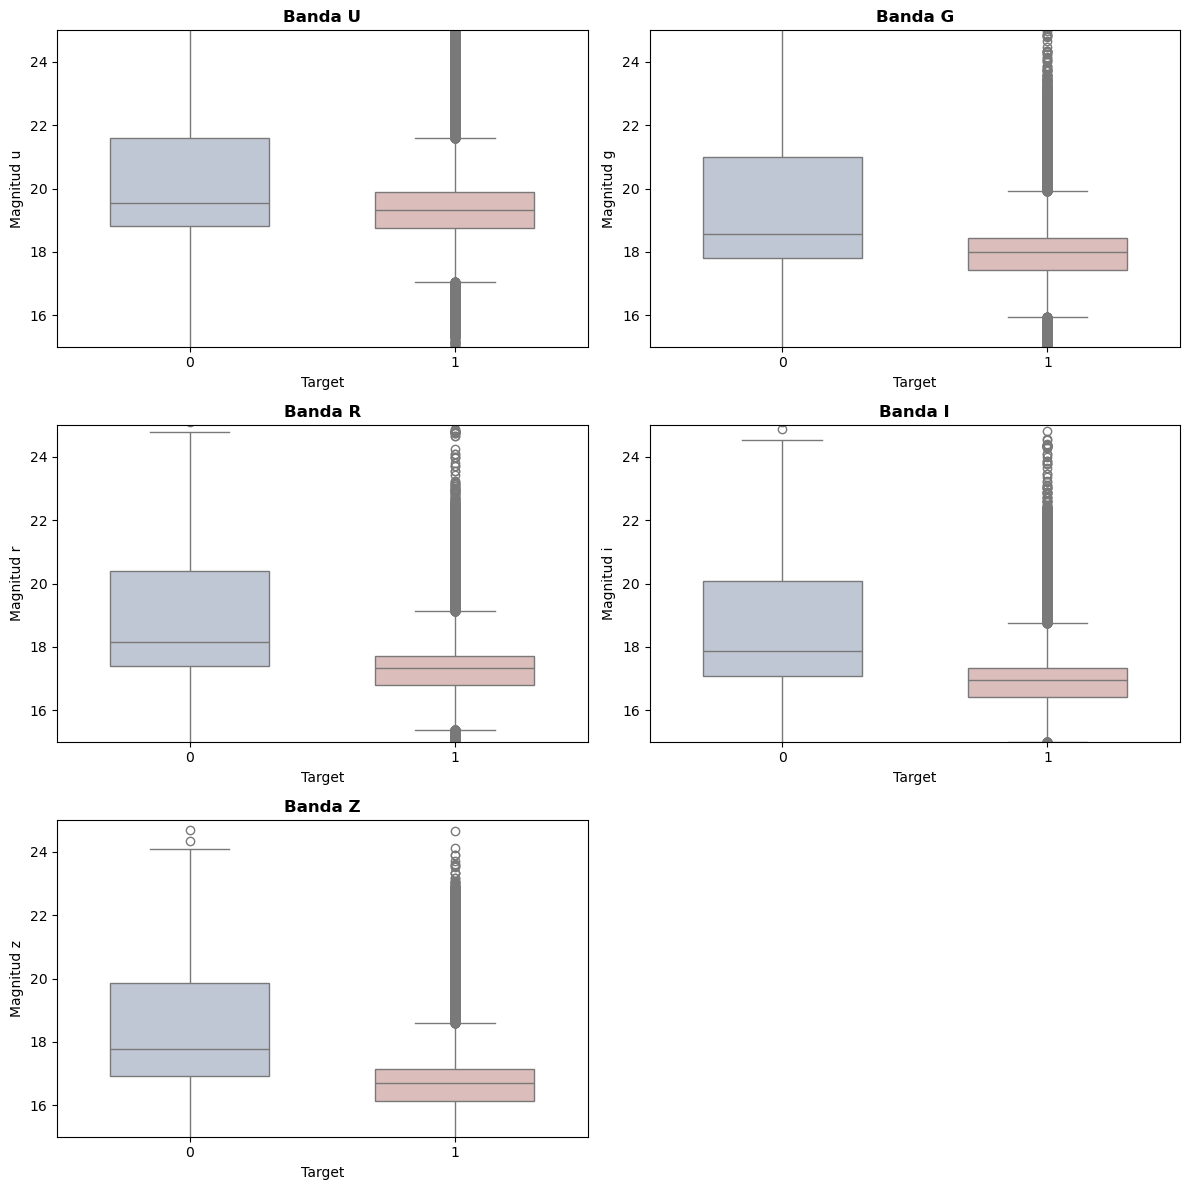

In [6]:
# Crear figura con subplots para las 5 bandas (3 filas x 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
bands = ['u', 'g', 'r', 'i', 'z']

# Aplanar el array de axes para iterar fácilmente
axes = axes.flatten()

for idx, band in enumerate(bands):
    sns.boxplot(data=df_train, x="target", y=band, hue="target", 
                width=.6, palette="vlag", legend=False, ax=axes[idx])
    axes[idx].set_title(f'Banda {band.upper()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Target', fontsize=10)
    axes[idx].set_ylabel(f'Magnitud {band}', fontsize=10)
    axes[idx].set_ylim(15, 25)

# Eliminar el último subplot (posición 6) ya que solo tenemos 5 bandas
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

Los gráficos muestran claramente las diferencias en las distribuciones de magnitudes entre las dos clases de galaxias (target 0 y 1) para cada banda fotométrica. Se observa clara separacion entre las clases.

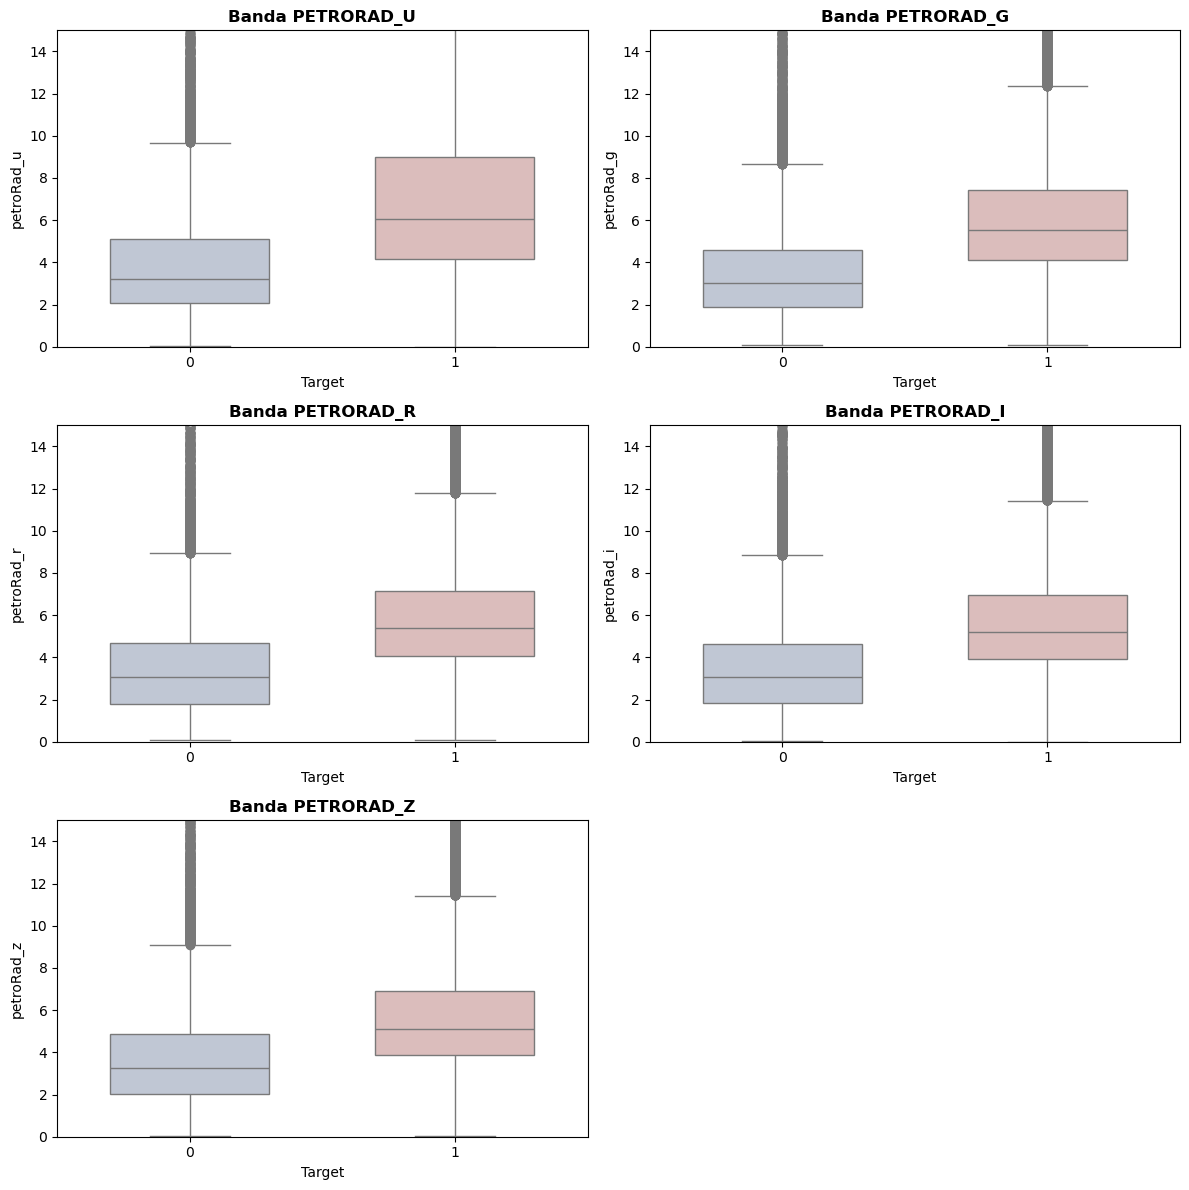

In [7]:
# Crear figura con subplots para las 5 bandas (3 filas x 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
petroRad_bands = ['petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z']

# Aplanar el array de axes para iterar fácilmente
axes = axes.flatten()

for idx, band in enumerate(petroRad_bands):
    sns.boxplot(data=df_train, x="target", y=band, hue="target", 
                width=.6, palette="vlag", legend=False, ax=axes[idx])
    axes[idx].set_title(f'Banda {band.upper()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Target', fontsize=10)
    axes[idx].set_ylabel(f'{band}', fontsize=10)
    # Ajustar el rango del eje Y
    axes[idx].set_ylim(0, 15)  

# Eliminar el último subplot (posición 6) ya que solo tenemos 5 bandas
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

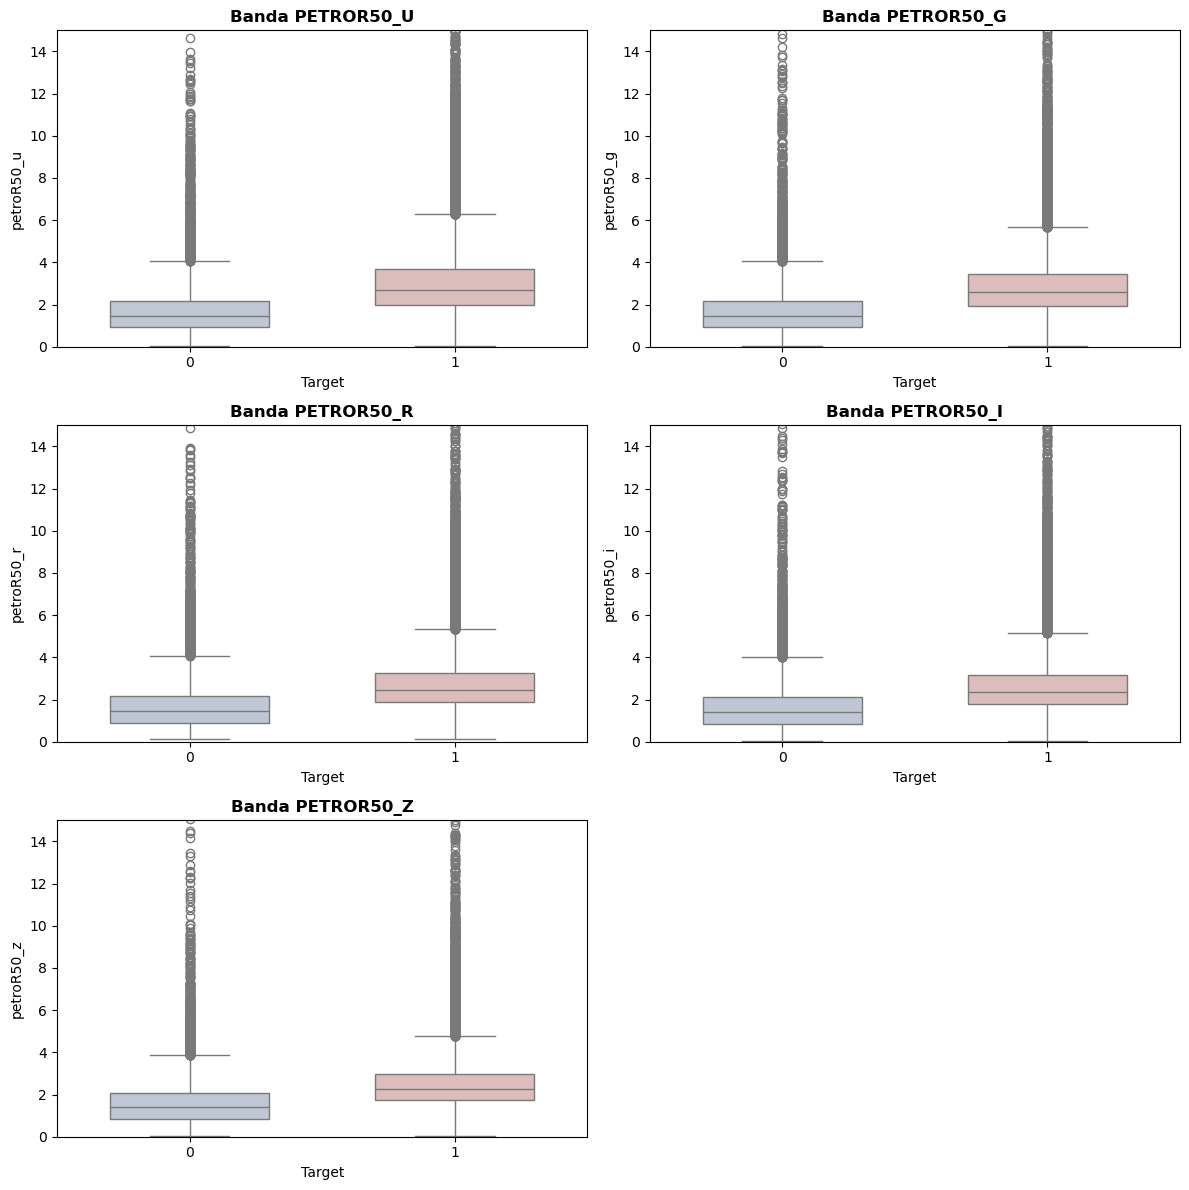

In [8]:
# Crear figura con subplots para las 5 bandas (3 filas x 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
petroR50_bands = ['petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z']

# Aplanar el array de axes para iterar fácilmente
axes = axes.flatten()

for idx, band in enumerate(petroR50_bands):
    sns.boxplot(data=df_train, x="target", y=band, hue="target", 
                width=.6, palette="vlag", legend=False, ax=axes[idx])
    axes[idx].set_title(f'Banda {band.upper()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Target', fontsize=10)
    axes[idx].set_ylabel(f'{band}', fontsize=10)
    # Ajustar el rango del eje Y
    axes[idx].set_ylim(0, 15)  

# Eliminar el último subplot (posición 6) ya que solo tenemos 5 bandas
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

(0.0, 6e-05)

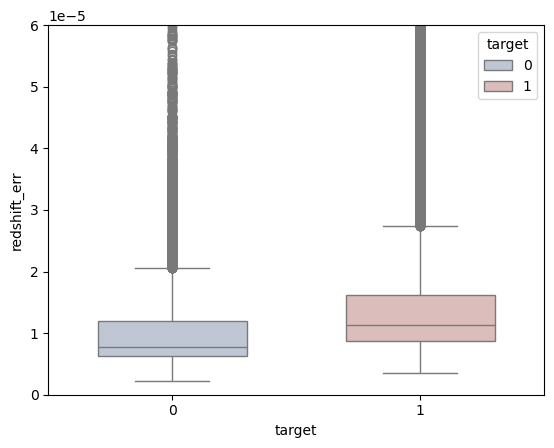

In [9]:
sns.boxplot(df_train, x="target", y="redshift_err", hue="target", width=.6, palette="vlag")
plt.ylim(0.0, 0.00006)

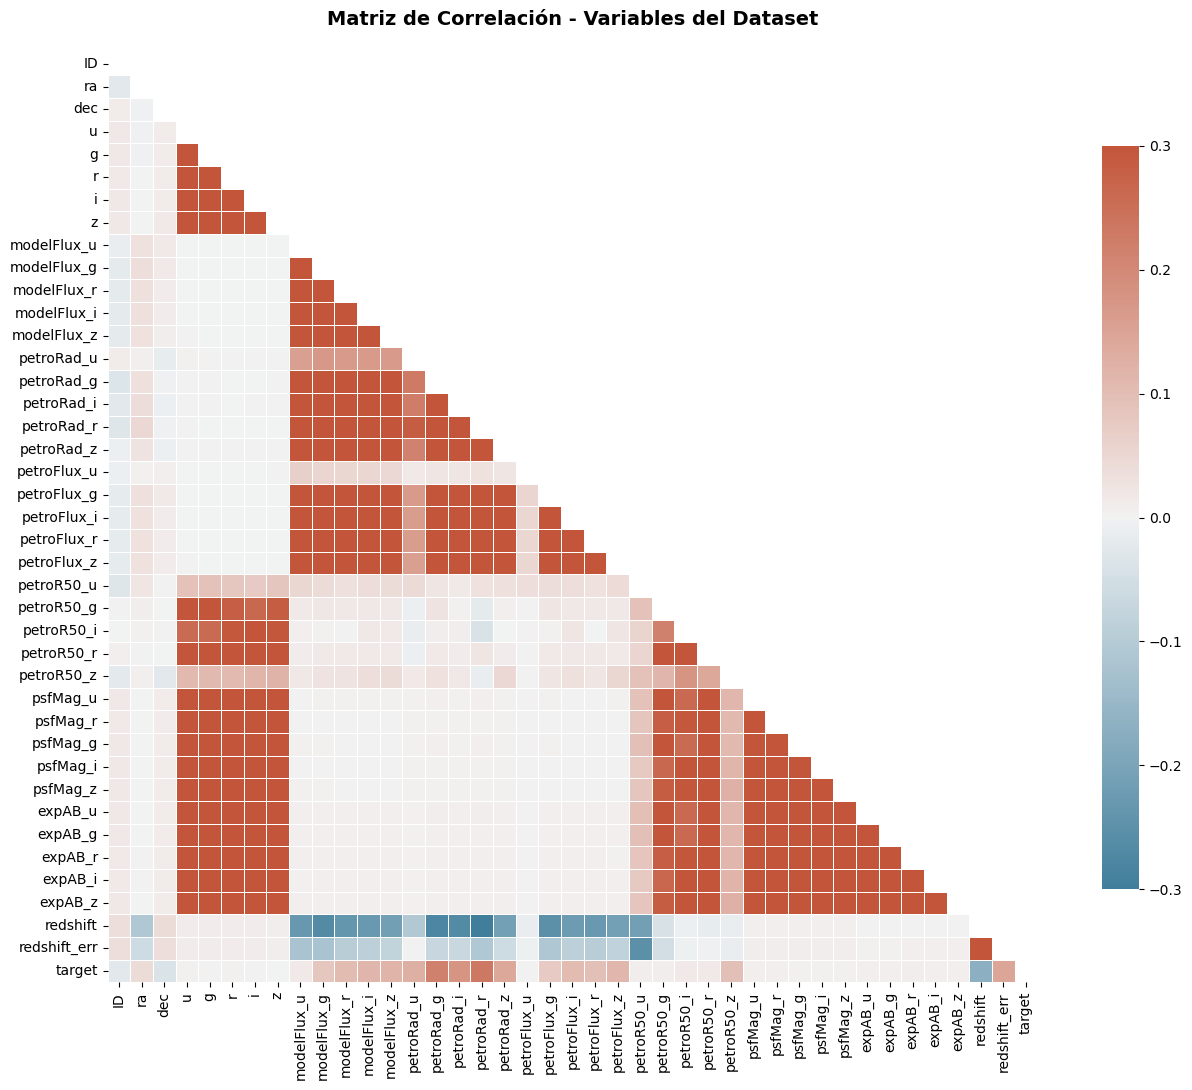

In [10]:
# Calcular la matriz de correlación
matriz_correlacion = df_train.corr()

# Generar una máscara para el triángulo superior (evitar duplicados)
mascara = np.triu(np.ones_like(matriz_correlacion, dtype=bool))

# Configurar la figura de matplotlib
fig, ax = plt.subplots(figsize=(14, 11))

# Generar un mapa de colores divergente personalizado
mapa_colores = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y aspecto correcto
sns.heatmap(matriz_correlacion, mask=mascara, cmap=mapa_colores, 
            vmin=-0.3, vmax=0.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8},
            annot=False, fmt='.2f')

plt.title('Matriz de Correlación - Variables del Dataset', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

Variables importantes para clasificación:

-Las variables con correlación moderada con target son las más útiles para el modelo
-Redshift muestra algunas correlaciones interesantes con otras variables

Multicolinealidad:

-Hay mucha multicolinealidad (variables muy correlacionadas entre sí). Esto puede afectar algunos modelos, pero Random Forest maneja bien la multicolinealidad

### Análisis de Correlaciones con Target

Antes de entrenar el modelo Random Forest, es fundamental entender **qué variables tienen mayor relación con nuestra variable objetivo (target)**. Esto nos permite:

1. **Identificar las características más predictivas**: Variables con correlación moderada-alta son las que mejor distinguen entre clases
2. **Detectar variables redundantes**: Si dos variables están muy correlacionadas entre sí, aportan información similar
3. **Optimizar el modelo**: Podemos priorizar o eliminar variables según su poder predictivo
4. **Entender el problema**: Las correlaciones nos dan insights sobre qué características físicas diferencian a las galaxias

#### ¿Qué buscamos en las correlaciones con target?

- **Correlación moderada: La variable es útil pero no redundante
- **Correlación baja: Poco poder predictivo, puede añadir ruido
- **Correlación muy alta: Posible data leakage o redundancia

A continuación, calculamos y visualizamos las correlaciones de todas las variables con `target` para identificar cuáles son las más importantes para nuestro modelo de clasificación.

CORRELACIÓN DE VARIABLES CON TARGET (ordenadas)
target          1.000000
petroRad_r      0.233720
petroRad_g      0.214498
petroRad_i      0.178160
redshift_err    0.147438
petroRad_z      0.141290
petroRad_u      0.127965
modelFlux_z     0.118146
modelFlux_i     0.112880
petroFlux_z     0.112112
petroFlux_i     0.104896
modelFlux_r     0.103338
petroFlux_r     0.094990
petroR50_z      0.094759
modelFlux_g     0.079974
petroFlux_g     0.077029
ra              0.042059
modelFlux_u     0.016205
petroR50_i      0.014810
petroR50_r      0.014681
petroR50_u      0.008760
expAB_r         0.008043
petroR50_g      0.007559
expAB_i         0.006721
psfMag_u        0.006221
expAB_z         0.005773
expAB_u         0.005735
psfMag_r        0.005680
expAB_g         0.005543
psfMag_g        0.004493
psfMag_i        0.004032
u               0.003414
r               0.002800
psfMag_z        0.002490
g               0.001794
i               0.001347
petroFlux_u     0.000152
z              -0.000006
ID

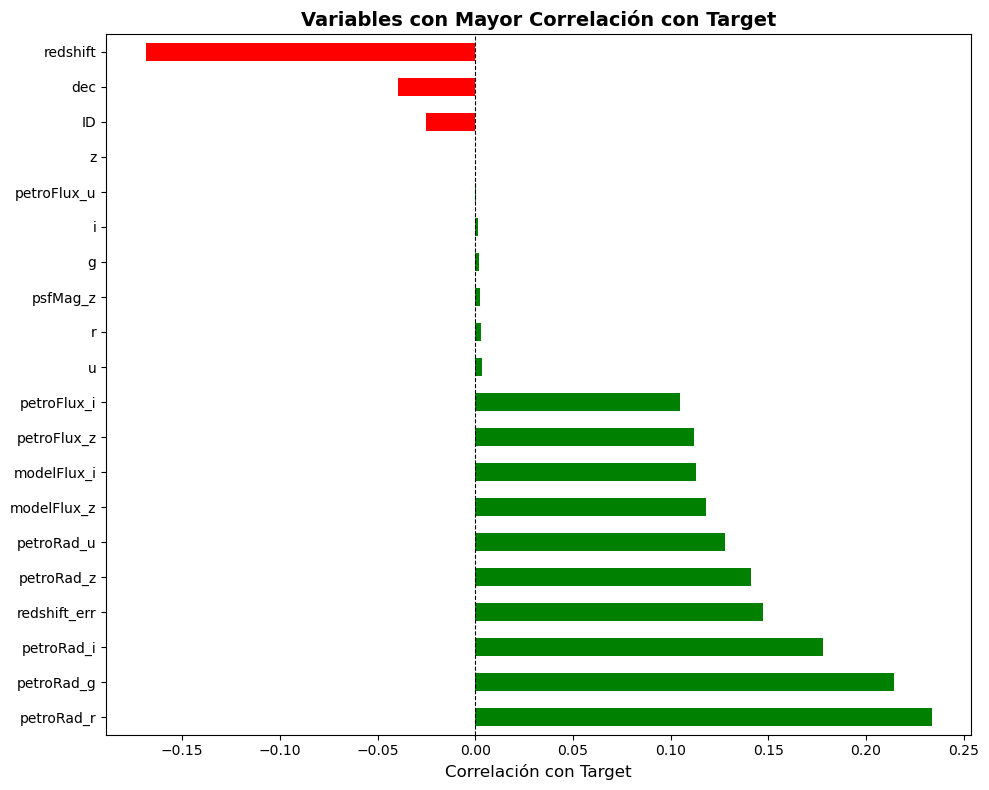

In [11]:
# Analizar la correlación de cada variable con 'target'
correlacion_con_target = df_train.corr()['target'].sort_values(ascending=False)

print("="*70)
print("CORRELACIÓN DE VARIABLES CON TARGET (ordenadas)")
print("="*70)
print(correlacion_con_target)

print("\n" + "="*70)
print("TOP 10 VARIABLES MÁS CORRELACIONADAS CON TARGET")
print("="*70)
print(correlacion_con_target.head(11)[1:])  # Excluir target consigo mismo

print("\n" + "="*70)
print("TOP 10 VARIABLES CON CORRELACIÓN NEGATIVA MÁS FUERTE")
print("="*70)
print(correlacion_con_target.tail(10))

# Visualizar las mejores correlaciones
fig, ax = plt.subplots(figsize=(10, 8))
top_correlaciones = pd.concat([
    correlacion_con_target.head(11)[1:],  # Top 10 positivas
    correlacion_con_target.tail(10)        # Top 10 negativas
])
colores = ['green' if x > 0 else 'red' for x in top_correlaciones.values]
top_correlaciones.plot(kind='barh', color=colores, ax=ax)
ax.set_xlabel('Correlación con Target', fontsize=12)
ax.set_title('Variables con Mayor Correlación con Target', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

## `Analisis de la estructura de los datos -> Limpieza de datos `

In [12]:
# Información básica de los conjuntos de datos
print("="*60)
print("CONJUNTO DE ENTRENAMIENTO (df_train)")
print("="*60)
print(f"Número de filas: {df_train.shape[0]}")
print(f"Número de columnas: {df_train.shape[1]}")
print(f"\nColumnas: {list(df_train.columns)}")
print(f"\nTipos de datos:")
print(df_train.dtypes)

CONJUNTO DE ENTRENAMIENTO (df_train)
Número de filas: 59998
Número de columnas: 41

Columnas: ['ID', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'modelFlux_u', 'modelFlux_g', 'modelFlux_r', 'modelFlux_i', 'modelFlux_z', 'petroRad_u', 'petroRad_g', 'petroRad_i', 'petroRad_r', 'petroRad_z', 'petroFlux_u', 'petroFlux_g', 'petroFlux_i', 'petroFlux_r', 'petroFlux_z', 'petroR50_u', 'petroR50_g', 'petroR50_i', 'petroR50_r', 'petroR50_z', 'psfMag_u', 'psfMag_r', 'psfMag_g', 'psfMag_i', 'psfMag_z', 'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z', 'redshift', 'redshift_err', 'target']

Tipos de datos:
ID                int64
ra              float64
dec             float64
u               float64
g               float64
r               float64
i               float64
z               float64
modelFlux_u     float64
modelFlux_g     float64
modelFlux_r     float64
modelFlux_i     float64
modelFlux_z     float64
petroRad_u      float64
petroRad_g      float64
petroRad_i      float64
petroRad_r      f

In [13]:
print("\n" + "="*60)
print("CONJUNTO DE PRUEBA (df_test)")
print("="*60)
print(f"Número de filas: {df_test.shape[0]}")
print(f"Número de columnas: {df_test.shape[1]}")
print(f"\nColumnas: {list(df_test.columns)}")
print(f"\nTipos de datos:")
print(df_test.dtypes)


CONJUNTO DE PRUEBA (df_test)
Número de filas: 40000
Número de columnas: 40

Columnas: ['ID', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'modelFlux_u', 'modelFlux_g', 'modelFlux_r', 'modelFlux_i', 'modelFlux_z', 'petroRad_u', 'petroRad_g', 'petroRad_i', 'petroRad_r', 'petroRad_z', 'petroFlux_u', 'petroFlux_g', 'petroFlux_i', 'petroFlux_r', 'petroFlux_z', 'petroR50_u', 'petroR50_g', 'petroR50_i', 'petroR50_r', 'petroR50_z', 'psfMag_u', 'psfMag_r', 'psfMag_g', 'psfMag_i', 'psfMag_z', 'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z', 'redshift', 'redshift_err']

Tipos de datos:
ID                int64
ra              float64
dec             float64
u               float64
g               float64
r               float64
i               float64
z               float64
modelFlux_u     float64
modelFlux_g     float64
modelFlux_r     float64
modelFlux_i     float64
modelFlux_z     float64
petroRad_u      float64
petroRad_g      float64
petroRad_i      float64
petroRad_r      float64
petroRad_z

Notamos que entre las muestras se distinguen por una columna "target".

In [14]:
# Estadísticas descriptivas del conjunto de entrenamiento
print("\n" + "="*60)
print("ESTADÍSTICAS DESCRIPTIVAS (ENTRENAMIENTO)")
print("="*60)
df_train.describe()


ESTADÍSTICAS DESCRIPTIVAS (ENTRENAMIENTO)


ID            ra           dec             u             g  \
count  5.999800e+04  59998.000000  59998.000000  59998.000000  59998.000000   
mean   1.237659e+18    180.384569     23.449607     18.126597     16.865635   
std    6.100020e+12     75.881812     21.172938    122.705999    122.690772   
min    1.237646e+18      0.009724    -11.244273  -9999.000000  -9999.000000   
25%    1.237655e+18    138.640727      2.999227     18.765855     17.510082   
50%    1.237659e+18    181.463258     20.898735     19.351790     18.074330   
75%    1.237663e+18    223.754866     42.304939     20.090335     18.662650   
max    1.237681e+18    359.993947     68.694746     30.806540     29.323290   

                  r             i             z   modelFlux_u   modelFlux_g  \
count  59998.000000  59998.000000  59998.000000  59998.000000  59998.000000   
mean      16.563169     16.037549     15.658734     30.055777     96.794240   
std      108.200242    115.664710    122.676784     69.571287    200.295311   
min    -9999.000000  -9999.000000  -9999.000000    -41.197150     -4.341232   
25%       16.903970     16.533660     16.289337      9.194943     34.240767   
50%       17.462595     17.095825     16.863815     18.163075     58.910855   
75%       17.939502     17.604725     17.465097     31.148128     99.017768   
max       30.430370     30.562360     27.945680   7192.298000   9013.129000   

       ...      psfMag_i      psfMag_z       expAB_u       expAB_g  \
count  ...  59998.000000  59998.000000  59998.000000  59998.000000   
mean   ...     17.691225     17.240204     -1.003568     -0.920878   
std    ...    115.678567    122.690936    122.462459    122.463432   
min    ...  -9999.000000  -9999.000000  -9999.000000  -9999.000000   
25%    ...     18.299955     17.996275      0.299999      0.399881   
50%    ...     18.851620     18.568260      0.509175      0.589641   
75%    ...     19.595282     19.303463      0.699986      0.770352   
max    ...     25.966680     23.478590      1.000000      1.000000   

            expAB_r       expAB_i       expAB_z      redshift  redshift_err  \
count  59998.000000  59998.000000  59998.000000  59998.000000  59998.000000   
mean      -0.575042     -0.742777     -0.940974      0.117153      0.000014   
std      108.004569    115.460737    122.463198      0.100733      0.000013   
min    -9999.000000  -9999.000000  -9999.000000     -0.000619      0.000002   
25%        0.419802      0.419094      0.381224      0.055743      0.000008   
50%        0.605789      0.605105      0.575589      0.085866      0.000011   
75%        0.775132      0.774710      0.752549      0.135511      0.000015   
max        0.999999      0.999999      0.999998      0.572899      0.000199   

             target  
count  59998.000000  
mean       0.749942  
std        0.433050  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000  

[8 rows x 41 columns]

In [15]:
# Estadísticas descriptivas del conjunto de prueba
print("\n" + "="*60)
print("ESTADÍSTICAS DESCRIPTIVAS (PRUEBA)")
print("="*60)
df_test.describe()


ESTADÍSTICAS DESCRIPTIVAS (PRUEBA)


ID            ra           dec             u             g  \
count  4.000000e+04  40000.000000  40000.000000  40000.000000  40000.000000   
mean   1.237659e+18    180.863987     23.507057     19.106625     17.847067   
std    6.109423e+12     75.553877     21.092662     70.857800     70.849375   
min    1.237646e+18      0.008745    -11.200748  -9999.000000  -9999.000000   
25%    1.237655e+18    138.941503      3.311895     18.756690     17.498020   
50%    1.237659e+18    181.538095     20.934352     19.347350     18.069970   
75%    1.237663e+18    224.079153     42.204431     20.060248     18.648165   
max    1.237681e+18    359.997922     68.695258     30.960000     30.420980   

                  r             i             z   modelFlux_u   modelFlux_g  \
count  40000.000000  40000.000000  40000.000000  40000.000000  40000.000000   
mean      17.209577     16.850184     16.139035     31.624601    101.921426   
std       70.844491     70.842393    100.170583     85.962368    267.324073   
min    -9999.000000  -9999.000000  -9999.000000    -47.451720    -11.935840   
25%       16.890163     16.516310     16.269150      9.455754     34.726708   
50%       17.454535     17.085105     16.855590     18.239615     59.155970   
75%       17.910295     17.577510     17.437775     31.424298    100.171225   
max       31.173560     27.217020     28.553240   7915.306000  18668.400000   

       ...      psfMag_g      psfMag_i      psfMag_z       expAB_u  \
count  ...  40000.000000  40000.000000  40000.000000  40000.000000   
mean   ...     19.427684     18.513630     17.728979     -0.003891   
std    ...     70.851618     70.845623    100.180016     70.706683   
min    ...  -9999.000000  -9999.000000  -9999.000000  -9999.000000   
25%    ...     19.251368     18.289525     17.982107      0.300000   
50%    ...     19.758795     18.837480     18.555120      0.508073   
75%    ...     20.399640     19.573495     19.292885      0.699312   
max    ...     25.117280     24.641680     27.043280      0.999984   

            expAB_g       expAB_r       expAB_i       expAB_z      redshift  \
count  40000.000000  40000.000000  40000.000000  40000.000000  40000.000000   
mean       0.075965      0.088850      0.088718     -0.441019      0.116154   
std       70.707181     70.707248     70.707245     99.992128      0.099317   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000     -0.000833   
25%        0.397487      0.417304      0.417922      0.381436      0.056027   
50%        0.586307      0.603080      0.602872      0.575022      0.085830   
75%        0.766260      0.772215      0.771340      0.751698      0.134560   
max        0.999999      0.999998      1.000000      0.999998      0.568725   

       redshift_err  
count  40000.000000  
mean       0.000427  
std        0.082518  
min        0.000003  
25%        0.000008  
50%        0.000011  
75%        0.000015  
max       16.503710  

[8 rows x 40 columns]

Observamos valores como -9999.0 que podrian afectar mas adelante. Luego quiero ver cuantas columnas por parametro tienen dicho valor.

In [16]:
# Contar valores anomalos como -9999 en el conjunto de prueba
print("="*60)
print("BÚSQUEDA DE VALORES ANÓMALOS (-9999) EN PRUEBA")
print("="*60)

# Contar valores -9999 por columna
anomalous_counts_test = {}
for col in df_test.columns:
    count_9999 = (df_test[col] == -9999).sum()
    if count_9999 > 0:
        anomalous_counts_test[col] = count_9999
        print(f"\n{col}: {count_9999} valores con 9999 ({count_9999/len(df_test)*100:.2f}%)")

if not anomalous_counts_test:
    print("\nNo se encontraron valores -9999 en el conjunto de prueba")


BÚSQUEDA DE VALORES ANÓMALOS (-9999) EN PRUEBA

u: 2 valores con 9999 (0.01%)

g: 2 valores con 9999 (0.01%)

r: 2 valores con 9999 (0.01%)

i: 2 valores con 9999 (0.01%)

z: 4 valores con 9999 (0.01%)

petroR50_u: 607 valores con 9999 (1.52%)

petroR50_g: 67 valores con 9999 (0.17%)

petroR50_i: 51 valores con 9999 (0.13%)

petroR50_r: 30 valores con 9999 (0.07%)

petroR50_z: 354 valores con 9999 (0.89%)

psfMag_u: 2 valores con 9999 (0.01%)

psfMag_r: 2 valores con 9999 (0.01%)

psfMag_g: 2 valores con 9999 (0.01%)

psfMag_i: 2 valores con 9999 (0.01%)

psfMag_z: 4 valores con 9999 (0.01%)

expAB_u: 2 valores con 9999 (0.01%)

expAB_g: 2 valores con 9999 (0.01%)

expAB_r: 2 valores con 9999 (0.01%)

expAB_i: 2 valores con 9999 (0.01%)

expAB_z: 4 valores con 9999 (0.01%)


In [17]:
# Revisar también valores maximos por columna
print("\n" + "="*60)
print("VALORES MÁXIMOS POR COLUMNA (PRUEBA)")
print("="*60)
for col in df_test.select_dtypes(include=['float64', 'int64']).columns:
    max_val = df_test[col].max()
    if max_val > 1000:  # Mostrar solo valores grandes
        print(f"{col}: {max_val}")


VALORES MÁXIMOS POR COLUMNA (PRUEBA)
ID: 1237680530279302063
modelFlux_u: 7915.306
modelFlux_g: 18668.4
modelFlux_r: 31755.99
modelFlux_i: 51923.48
modelFlux_z: 79058.46
petroFlux_u: 12842.41
petroFlux_g: 26830.07
petroFlux_i: 73220.98
petroFlux_r: 49008.36
petroFlux_z: 85984.48


In [18]:
# Buscar valores anómalos como -9999 en el conjunto de entrenamiento
print("="*60)
print("BÚSQUEDA DE VALORES ANÓMALOS (-9999) EN ENTRENAMIENTO")
print("="*60)

# Contar valores 9999 por columna
anomalous_counts_train = {}
for col in df_train.columns:
    count_9999 = (df_train[col] == -9999).sum()
    if count_9999 > 0:
        anomalous_counts_train[col] = count_9999
        print(f"\n{col}: {count_9999} valores con -9999 ({count_9999/len(df_train)*100:.2f}%)")

if not anomalous_counts_train:
    print("\nNo se encontraron valores -9999 en el conjunto de entrenamiento")

BÚSQUEDA DE VALORES ANÓMALOS (-9999) EN ENTRENAMIENTO

u: 9 valores con -9999 (0.02%)

g: 9 valores con -9999 (0.02%)

r: 7 valores con -9999 (0.01%)

i: 8 valores con -9999 (0.01%)

z: 9 valores con -9999 (0.02%)

petroR50_u: 963 valores con -9999 (1.61%)

petroR50_g: 87 valores con -9999 (0.15%)

petroR50_i: 80 valores con -9999 (0.13%)

petroR50_r: 38 valores con -9999 (0.06%)

petroR50_z: 569 valores con -9999 (0.95%)

psfMag_u: 9 valores con -9999 (0.02%)

psfMag_r: 7 valores con -9999 (0.01%)

psfMag_g: 9 valores con -9999 (0.02%)

psfMag_i: 8 valores con -9999 (0.01%)

psfMag_z: 9 valores con -9999 (0.02%)

expAB_u: 9 valores con -9999 (0.02%)

expAB_g: 9 valores con -9999 (0.02%)

expAB_r: 7 valores con -9999 (0.01%)

expAB_i: 8 valores con -9999 (0.01%)

expAB_z: 9 valores con -9999 (0.02%)


In [19]:
# Revisar también valores maximos por columna
print("\n" + "="*60)
print("VALORES MÁXIMOS POR COLUMNA (ENTRENAMIENTO)")
print("="*60)
for col in df_train.select_dtypes(include=['float64', 'int64']).columns:
    max_val = df_train[col].max()
    if max_val > 1000:  # Mostrar solo valores grandes
        print(f"{col}: {max_val}")


VALORES MÁXIMOS POR COLUMNA (ENTRENAMIENTO)
ID: 1237680530810929644
modelFlux_u: 7192.298
modelFlux_g: 9013.129
modelFlux_r: 22205.48
modelFlux_i: 37970.16
modelFlux_z: 56688.75
petroFlux_u: 5091.803
petroFlux_g: 10103.74
petroFlux_i: 35993.26
petroFlux_r: 21312.13
petroFlux_z: 50039.27


Notamos que los valores -9999.0 en porcentajes son maximos en los parametros: petroR50_u, petroR50_g, petroR50_r, petroR50_i, petroR50_z.

Procedemos a preparar la muestra de entrenamiento para un entrenamiento optimo del Modelo Random Forest.

In [20]:
# --- 2. Manejo de -9999 (Placeholder)  ---

# Columnas de magnitud y forma identificadas con el placeholder -9999 en el EDA
cols_to_clean = [
    'u', 'g', 'r', 'i', 'z', 'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z',
    'psfMag_u', 'psfMag_r', 'psfMag_g', 'psfMag_i', 'psfMag_z',
    'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z'
]

# Reemplazar -9999.0 por NaN en ambos sets
df_train[cols_to_clean] = df_train[cols_to_clean].replace(-9999.0, np.nan)
df_test[cols_to_clean] = df_test[cols_to_clean].replace(-9999.0, np.nan)

# Calcular la mediana SOLO del set de entrenamiento
imputation_medians = df_train[cols_to_clean].median()

# Imputar NaN con la mediana del set de entrenamiento (evitando Data Leakage)
df_train[cols_to_clean] = df_train[cols_to_clean].fillna(imputation_medians)
df_test[cols_to_clean] = df_test[cols_to_clean].fillna(imputation_medians)

print(f"✅ Valores -9999 reemplazados con la mediana.")



# --- 3. Manejo de Outliers ---

# Aplicar capping a variables importantes - alta correlación con target
outlier_cols_to_cap = [
    'redshift_err', 'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z',
]

def handle_outliers_iqr(df, column):
    """Limita los valores extremos de una columna usando el rango intercuartílico (IQR)."""
    if column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Aplicar capping: asignar el límite al valor que lo excede
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Aplicar la función de manejo de outliers a ambos DataFrames
outliers_procesados = 0
for col in outlier_cols_to_cap:
    if col in df_train.columns:
        df_train = handle_outliers_iqr(df_train, col)
        df_test = handle_outliers_iqr(df_test, col)
        outliers_procesados += 1

print(f"✅ Outliers limitados (capping) en {outliers_procesados} variables importantes.")


# --- 5. Guardar los DataFrames Limpios y con Features ---
df_train.to_csv('galaxy_train_cleaned.csv', index=False)
df_test.to_csv('galaxy_test_cleaned.csv', index=False)


✅ Valores -9999 reemplazados con la mediana.
✅ Outliers limitados (capping) en 6 variables importantes.


## `Entrenamiento de Modelo`

### Feature Engineering Avanzado
Creamos nuevas características a partir de las existentes para mejorar el rendimiento del modelo.

In [21]:
# 1. Crear ratios entre bandas (muy importantes en astronomía)
df_train['u_g_ratio'] = df_train['u'] / df_train['g']
df_train['g_r_ratio'] = df_train['g'] / df_train['r'] 
df_train['r_i_ratio'] = df_train['r'] / df_train['i']
df_train['i_z_ratio'] = df_train['i'] / df_train['z']

df_test['u_g_ratio'] = df_test['u'] / df_test['g']
df_test['g_r_ratio'] = df_test['g'] / df_test['r']
df_test['r_i_ratio'] = df_test['r'] / df_test['i'] 
df_test['i_z_ratio'] = df_test['i'] / df_test['z']

# 2. Diferencias entre bandas
df_train['g_minus_r'] = df_train['g'] - df_train['r']
df_train['r_minus_i'] = df_train['r'] - df_train['i']
df_train['i_minus_z'] = df_train['i'] - df_train['z']

df_test['g_minus_r'] = df_test['g'] - df_test['r']
df_test['r_minus_i'] = df_test['r'] - df_test['i']
df_test['i_minus_z'] = df_test['i'] - df_test['z']

print("✅ Features de colores creadas (ratios y diferencias)")

✅ Features de colores creadas (ratios y diferencias)


In [22]:
# 3. Features basadas en radios petrosianos
df_train['petroR50_mean'] = df_train[['petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z']].mean(axis=1)
df_train['petroR50_std'] = df_train[['petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z']].std(axis=1)
df_train['petroR50_max'] = df_train[['petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z']].max(axis=1)

df_test['petroR50_mean'] = df_test[['petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z']].mean(axis=1)
df_test['petroR50_std'] = df_test[['petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z']].std(axis=1)
df_test['petroR50_max'] = df_test[['petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z']].max(axis=1)

# 4. Features de magnitudes
df_train['magnitude_sum'] = df_train[['u', 'g', 'r', 'i', 'z']].sum(axis=1)
df_train['magnitude_mean'] = df_train[['u', 'g', 'r', 'i', 'z']].mean(axis=1)

df_test['magnitude_sum'] = df_test[['u', 'g', 'r', 'i', 'z']].sum(axis=1)  
df_test['magnitude_mean'] = df_test[['u', 'g', 'r', 'i', 'z']].mean(axis=1)

print("✅ Features estadísticas creadas")

✅ Features estadísticas creadas


### Optimización de Hiperparámetros con GridSearch
Optimizamos tanto LightGBM como Random Forest con búsqueda exhaustiva de parámetros.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import lightgbm as lgb

# Preparar datos para entrenamiento
X = df_train.drop(['target'], axis=1)
y = df_train['target']
X_test = df_test.copy()

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Distribución de clases: {y.value_counts()}")

Shape de X: (59998, 52)
Shape de y: (59998,)
Shape de X_test: (40000, 52)
Distribución de clases: target
1    44995
0    15003
Name: count, dtype: int64


In [25]:
# 1. Optimización Random Forest
print("🔍 Optimizando Random Forest...")

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, None],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_grid.fit(X, y)

print(f"✅ Mejores parámetros RF: {rf_grid.best_params_}")
print(f"✅ Mejor score RF: {rf_grid.best_score_:.5f}")

🔍 Optimizando Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Mejores parámetros RF: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
✅ Mejor score RF: 0.95276
✅ Mejores parámetros RF: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
✅ Mejor score RF: 0.95276


In [26]:
# 2. Optimización LightGBM
print("🔍 Optimizando LightGBM...")

lgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01],
    'max_depth': [5, 15],
    'num_leaves': [50],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
lgb_grid.fit(X, y)

print(f"✅ Mejores parámetros LGB: {lgb_grid.best_params_}")
print(f"✅ Mejor score LGB: {lgb_grid.best_score_:.5f}")

🔍 Optimizando LightGBM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
✅ Mejores parámetros LGB: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 300, 'num_leaves': 50, 'subsample': 0.8}
✅ Mejor score LGB: 0.95407
✅ Mejores parámetros LGB: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 300, 'num_leaves': 50, 'subsample': 0.8}
✅ Mejor score LGB: 0.95407


### Ensemble: Combinando los Mejores Modelos
Combinamos las predicciones de ambos modelos optimizados para obtener el mejor resultado.

In [27]:
# Obtener predicciones de probabilidad de ambos modelos
rf_proba = rf_grid.best_estimator_.predict_proba(X_test)[:, 1]
lgb_proba = lgb_grid.best_estimator_.predict_proba(X_test)[:, 1]

# Combinar predicciones (promedio ponderado)
ensemble_proba = 0.4 * rf_proba + 0.6 * lgb_proba  # Damos más peso a LightGBM

# Predicciones finales
ensemble_pred = (ensemble_proba > 0.5).astype(int)

print(f"Predicciones RF (primeras 10): {rf_proba[:10]}")
print(f"Predicciones LGB (primeras 10): {lgb_proba[:10]}")
print(f"Predicciones Ensemble (primeras 10): {ensemble_proba[:10]}")
print(f"Distribución predicciones: {np.bincount(ensemble_pred)}")

Predicciones RF (primeras 10): [0.91888889 0.98877778 0.92378968 1.         0.08283333 0.45527778
 0.48161111 0.95077778 0.99833333 1.        ]
Predicciones LGB (primeras 10): [0.95528691 0.9571892  0.97128289 0.97887929 0.09807263 0.49058506
 0.1388128  0.96518627 0.98067159 0.98023905]
Predicciones Ensemble (primeras 10): [0.9407277  0.96982463 0.95228561 0.98732757 0.09197691 0.47646215
 0.27593213 0.95942287 0.98773629 0.98814343]
Distribución predicciones: [ 8918 31082]


In [29]:
# Crear archivo de submisión con ID y target (formato correcto)
# Usar los IDs reales del dataset de prueba
test_ids = pd.read_csv('galaxy_test_cleaned.csv')['ID']
submission = pd.DataFrame({
    'ID': test_ids,
    'target': ensemble_pred
})

# Guardar submisión
submission.to_csv('submission_ensemble_RF_LGB.csv', index=False)

print("🎯 Archivo de submisión creado: submission_ensemble_RF_LGB.csv")
print(f"📊 Estadísticas de la submisión:")
print(f"   - Clase 0: {(ensemble_pred == 0).sum()}")
print(f"   - Clase 1: {(ensemble_pred == 1).sum()}")
print(f"   - Total de filas: {len(submission)}")

# Mostrar primeras filas
print(f"\nFormato de submisión (primeras 10 filas):")
print(submission.head(10))

🎯 Archivo de submisión creado: submission_ensemble_RF_LGB.csv
📊 Estadísticas de la submisión:
   - Clase 0: 8918
   - Clase 1: 31082
   - Total de filas: 40000

Formato de submisión (primeras 10 filas):
                    ID  target
0  1237656906355048679       1
1  1237648721225711796       1
2  1237655473438851815       1
3  1237651274034184295       1
4  1237661125612142849       0
5  1237666301091578136       0
6  1237648702974394453       0
7  1237651272438055029       1
8  1237661871339012209       1
9  1237657118947475690       1
